In [36]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.special as sp
import scipy.misc as misc
import warnings
import torch as th
%matplotlib inline

dtype = th.float

# Uncomment for device type
device = th.device("cuda:0")
# device = th.device("cpu")

In [37]:
# Open files
with open("mnist_dataset/mnist_test.csv", 'r') as test_file:
    test_list = test_file.readlines()

with open("mnist_dataset/mnist_train.csv", 'r') as train_file:
    train_list = train_file.readlines()

In [38]:
# Testing.
def softmax(x):
    e_x = th.exp(x - th.max(x))
    return e_x / e_x.sum(axis=0)

def test(network, supress_outputs=True):
    verification = list()

    for record in test_list:
        record = record.split(',')

        # Get the label
        correct_label = int(record[0])

        # Scale it for input
        scaled_input = np.asfarray(record[1:]) / 255.0 * 0.99 + 0.01

        # Get the result
        result = network.query(scaled_input).cpu()

        # Apply SoftMax
        result = softmax(result)

        # Get the predicted label
        predicted_label = np.argmax(result)

        if predicted_label == correct_label:
            verification.append(1)
        else:
            verification.append(0)

    if not supress_outputs:
        print(f"Out of {len(verification)} images, the network correctly predicted {sum(verification)}")
        print(
            f"Accuracy is {np.round(sum(verification) / len(verification) * 100, 2)}%")
    
    return sum(verification) / len(verification)

In [39]:
class NeuralNetwork(object):
    def __init__(self, dimensions, learning_rate: float, activation_function: str = "relu"):
        if len(dimensions) < 2:
            raise TypeError(
                "dimensions argument needs to have at least two elements")

        # Set object properties
        self.learning_rate = learning_rate
        self.dimensions = dimensions

        self.init_layers()

        # Activation function selector
        match activation_function.lower():
            case "sigmoid":
                self.method = "sigmoid"
                self.activation_function = th.nn.Sigmoid()
                self.init_weights()
            case "relu":
                self.method = "relu"
                self.activation_function = th.nn.ReLU()
                self.init_weights()
            case _:
                self.method = "relu"
                self.activation_function = th.nn.ReLU()
                self.init_weights()

                warnings.warn(
                    f"'{activation_function}' is not a valid parameter for activation function, defaulting to ReLU.")

    # Builds the necessary numpy vectors for representing the layer nodes
    def init_layers(self):
        self.layers = list()

        for index in range(len(self.dimensions)):
            # Vectors of node_count rows
            self.layers.append(th.empty(size=(self.dimensions[index], 1), device=device, dtype=dtype))

    # Builds the necessary numpy matrices for representing the weights
    def init_weights(self):
        self.weights = list()

        for index in range(len(self.dimensions) - 1):
            # Matrices must have the next layer's node count as rows and the current layer's node count as columns
            # For example, the first layer after input will receive
            # WeightMatrix * InputVector and it must result into a vector of the next layer's rows.
            current_layer_node_count = self.dimensions[index]
            next_layer_node_count = self.dimensions[index + 1]

            match self.method:
                case "relu":
                    # Using Glorot Normal Initialization
                    # (https://stats.stackexchange.com/questions/339054/what-values-should-initial-weights-for-a-relu-network-be)
                    # standard_deviation = sqrt(2 / (fan_in + fan_out))
                    standard_deviation = th.sqrt(
                        2 / (current_layer_node_count + next_layer_node_count))
                    self.weights.append(
                        th.normal(
                            mean=0.0,
                            std=standard_deviation,
                            size=(next_layer_node_count,
                                  current_layer_node_count),
                            device=device,
                            dtype=dtype
                        ) + 0.01
                    )
                case "sigmoid":
                    self.weights.append(
                        th.rand(
                            size=(next_layer_node_count,
                                  current_layer_node_count),
                            device=device,
                            dtype=dtype
                        ) - 0.5
                    )

    # Trains the neural network using backpropagation
    def train(self, inputs_list, targets_list):
        targets = th.from_numpy(np.array(targets_list, ndmin=2).T).float().to(device)

        # Let's run the input through
        self.query(inputs_list)

        # Computing the cost function
        # error = (target - final_output)
        error_vector = (targets - self.layers[len(self.dimensions) - 1])

        # Update the weights
        for index in range(len(self.dimensions) - 2, -1, -1):
            # Choose partial derivative
            match self.method:
                case "relu":
                    self.weights[index] += self.learning_rate * th.matmul(
                        error_vector * th.heaviside(self.layers[index + 1], 1), self.layers[index].t())
                case "sigmoid":
                    self.weights[index] += self.learning_rate * th.matmul(
                        error_vector * self.layers[index + 1] * (1 - self.layers[index + 1]), self.layers[index].t())

            # Propagate errors accordingly
            if index != 0:
                error_vector = th.matmul(self.weights[index].t(), error_vector)

    # Queries the neural network
    def query(self, inputs_list):
        # Convert inputs list to 2d array
        self.layers[0] = th.from_numpy(np.array(inputs_list, ndmin=2).T).float().to(device)

        # Go through all layers and compute the outputs
        for index in range(1, len(self.dimensions)):
            self.layers[index] = th.matmul(
                self.weights[index - 1], self.layers[index - 1]
            )
            self.layers[index] = self.activation_function(self.layers[index])

        return self.layers[len(self.dimensions) - 1]


In [40]:
# Creating the network

# 784 pixels for input layer, 2 20-nodes hidden layers and one 10-node output layer
dimensions = np.array([28 * 28, 500, 10])
learning_rate = 0.12

network = NeuralNetwork(dimensions=dimensions,
                  activation_function="sigmoid", learning_rate=learning_rate)

performance = []

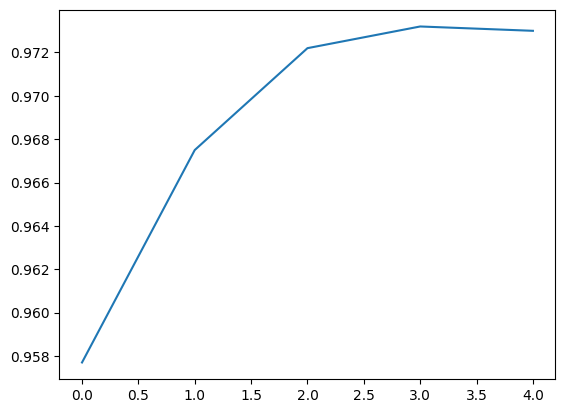

In [43]:
# Training

epochs = 2
for epoch in range(epochs):
    for index, record in enumerate(train_list):
        # Transform one of them to an image
        record = record.split(',')

        # Scale input to [0.01, 1.00]
        scaled_input = np.asfarray(record[1:]) / 255.0 * 0.99 + 0.01

        # Make output nodes
        nodes = 10
        targets = np.zeros(10) + 0.01
        targets[int(record[0])] = 0.99

        # Train.
        network.train(inputs_list=scaled_input, targets_list=targets)
    
    performance.append(test(network=network))
    
plt.plot(np.arange(len(performance)), performance)
performance